In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
datasets, info = tfds.load(
    "imdb_reviews/plain_text",
    split=["train", "test[:50%]", "test[50%:]"],
    as_supervised=True,
    with_info=True
)
dataset_train_original    = datasets[0]
dataset_validate_original = datasets[1]
dataset_test_original     = datasets[2]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DMSJSM_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DMSJSM_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.DMSJSM_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
for x,y in dataset_train_original.shuffle(25).take(4):
  print(x.numpy().decode("utf-8")) # turns bytestrings into strings
  print(y)

In a time of magic, barbarians and demons abound a diabolical tyrant named Nekhron and his mother Queen Juliane who lives in the realm of ice and wants to conquer the region of fire ruled by the King Jerol but when his beautiful daughter Princess Teegra has been kidnapped by Nekhron's goons, a warrior named Larn must protect her and must defeat Nekhron from taking over the world and the kingdom with the help of an avenger named Darkwolf.<br /><br />A nicely done and excellent underrated animated fantasy epic that combines live actors with animation traced over them ( rotoscoping), it's Ralph Bakshi's second best movie only with "American Pop" being number one and "Heavy Traffic" being third and "Wizards" being fourth. It's certainly better than his "Cool World" or "Lord of the Rings", the artwork is designed by famed artist Frank Farzetta and the animation has good coloring and there's also a hottie for the guys.<br /><br />I highly recommend this movie to fantasy and animation lovers 

In [4]:
lengths = []
for x,_ in dataset_train_original:
  length = len(x.numpy().decode("utf-8").split())  # needs to convert to numpy because the data are in tensorflow format
  lengths += [length]

In [ ]:
plt.hist(lengths, bins=100)
plt.show()

In [5]:
shortest_sample = " " * 100_000
longest_sample = " "

for x, _ in dataset_train_original:
  x = x.numpy().decode("utf-8")
  if len(x) < len(shortest_sample):
    shortest_sample = x
  if len(x) > len(longest_sample):
    longest_sample = x

print(shortest_sample)
print(longest_sample)

This movie is terrible but it has some good effects.
Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle r

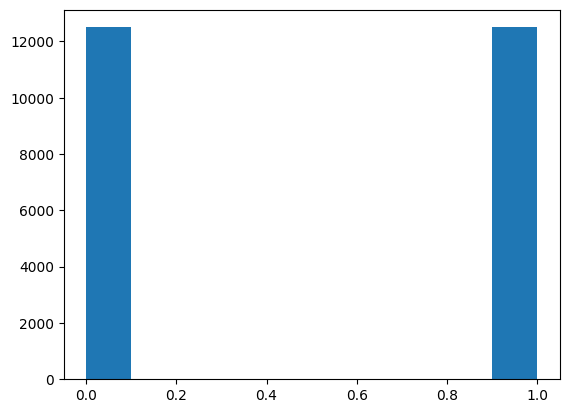

In [6]:
labels = []
for _, y in dataset_train_original:
  labels += [y.numpy()]

plt.hist(labels)
plt.show()

In [7]:
vocabulary_size = 10_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="multi_hot"
)

encoder.adapt(dataset_test_original.map(lambda text, label: text).batch(2048))

In [ ]:
print(encoder.get_vocabulary())

In [ ]:
np.argmax(encoder("hello").numpy())

In [8]:
dataset_train = dataset_train_original.cache().shuffle(25_000).batch(128) # cache speed up the iterations because data are keept in cache
dataset_validate = dataset_validate_original.cache().batch(128)
dataset_test = dataset_test_original.cache().batch(128)

In [9]:
model = models.Sequential()
model.add(encoder)
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(1))#, activation="sigmoid"))
#model.add(layers.Dense(2, activation="softmax"))
model.build(input_shape=(None,))
model.summary()

model.predict(tf.constant(["hello world"]))

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print(model.evaluate(dataset_test))

history = model.fit(
    dataset_train,
    epochs=4,
    validation_data=dataset_validate
)

print(model.evaluate(dataset_test))

# evaluate is needed to return loss and metric
# predict only return prediction (not metrics and loss)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 10000)               │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2)                   │          20,002 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               3 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,005 (78.14 KB)

 Trainable params: 20,005 (78.14 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
98/98 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.4980 - loss: 5.1362
[5.162667274475098, 0.49639999866485596]
Epoch 1/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.6289 - loss: 0.9630 - val_accuracy: 0.8316 - val_loss: 0.4234
Epoch 2/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8647 - loss: 0.3470 - val_accuracy: 0.8299 - val_loss: 0.4181
Epoch 3/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8834 - loss: 0.2910 - val_accuracy: 0.8600 - val_loss: 0.4081
Epoch 4/4
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9126 - loss: 0.2432 - val_accuracy: 0.8654 - val_loss: 0.4051
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8702 - loss: 0.3784
[0.39294686913490295, 0.8685600161552429]


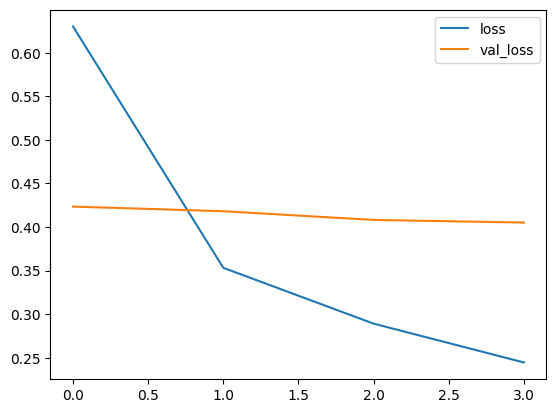

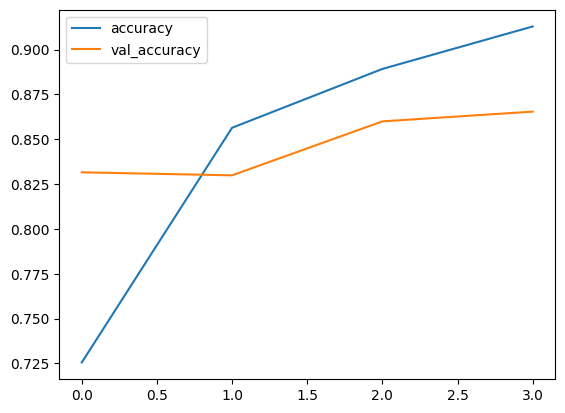

In [10]:
def render_history(history):

  plt.plot(history["loss"], label="loss")
  plt.plot(history["val_loss"], label="val_loss")
  plt.legend()
  plt.show()
  plt.plot(history["accuracy"], label="accuracy")
  plt.plot(history["val_accuracy"], label="val_accuracy")
  plt.legend()
  plt.show()

render_history(history.history)

In [ ]:
# Word Embedding

In [103]:
vocabulary_size = 10_000
sequence_length = 64

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    output_sequence_length=sequence_length,
    standardize="lower_and_strip_punctuation",
    split="whitespace",
    output_mode="int"
)
encoder.adapt(dataset_test_original.map(lambda text, label: text).batch(2048))

In [22]:
print(encoder.get_vocabulary()[:20])
print(encoder("how are you doing").numpy())

['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'i', 'it', 'this', 'that', 'br', 'was', 'as', 'with', 'for', 'movie', 'but']
[ 85  24  22 412   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [102]:
64*32

2048

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_10                │ (None, 64)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_15 (Embedding)             │ (None, 64, 32)              │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_9 (Reshape)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 32)                  │          65,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 385,601 (1.47 MB)

 Trainable params: 385,601 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.5901 - loss: 0.6544 - val_accuracy: 0.7786 - val_loss: 0.4658
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8599 - loss: 0.3356 - val_accuracy: 0.7826 - val_loss: 0.4744
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9599 - loss: 0.1471 - val_accuracy: 0.7648 - val_loss: 0.5794
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9965 - loss: 0.0352 - val_accuracy: 0.7632 - val_loss: 0.6919
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9998 - loss: 0.0084 - val_accuracy: 0.7656 - val_loss: 0.7632
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 0.7655 - val_loss: 0.8175
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.7658 - val_loss: 0.8592
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 1.0000 - loss: 0.0013 - val_acc

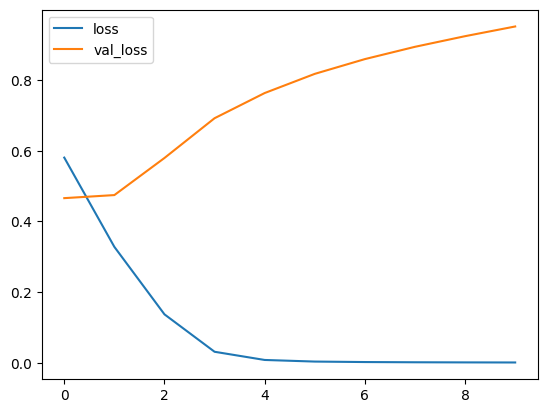

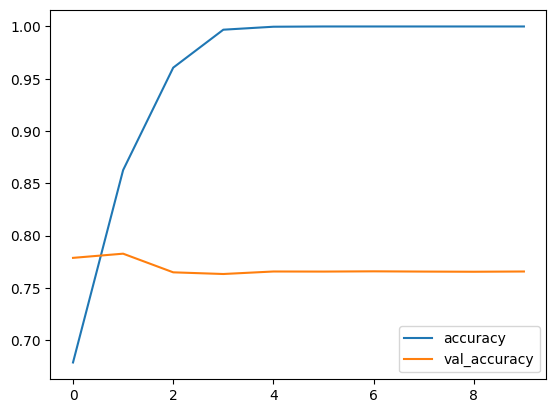

In [104]:
model = models.Sequential()
model.add(encoder)
model.add(layers.Embedding(input_dim=vocabulary_size, output_dim=32))
model.add(layers.Reshape((2048,)))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.build(input_shape=(None,))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

#print(model.evaluate(dataset_test))

history = model.fit(
    dataset_train,
    epochs=10,
    validation_data=dataset_validate
)

render_history(history.history)

In [46]:
model.layers[1].get_weights()[0].shape

(10000, 32)

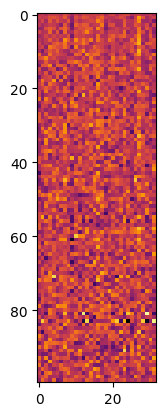

In [47]:
plt.imshow(model.layers[1].get_weights()[0][:100,::],cmap="inferno")

In [120]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# List of target words
words = ['germany', 'france', 'england', 'berlin', 'paris', 'london']
words = [
    'time', 'person', 'year', 'way', 'day', 'thing', 'man', 'world', 'life', 'hand',
    'part', 'child', 'eye', 'woman', 'place', 'work', 'week', 'case', 'point', 'government',
    'company', 'number', 'group', 'problem', 'fact', 'be', 'have', 'do', 'say', 'get'
]


# Retrieve the vocabulary from the embedding layer
vocab = model.layers[0].get_vocabulary()

# Get indices for the target words
indices = [vocab.index(word) for word in words if word in vocab]

# Extract embeddings for the target words
embeddings = model.layers[1].get_weights()[0]  # Assuming the embedding layer is the second layer
selected_embeddings = np.array([embeddings[idx] for idx in indices])

# Initialize t-SNE with desired parameters
tsne = TSNE(n_components=2, perplexity=1, n_iter=1000, random_state=42)

# Fit and transform the embeddings
X_embedded = tsne.fit_transform(selected_embeddings)



/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


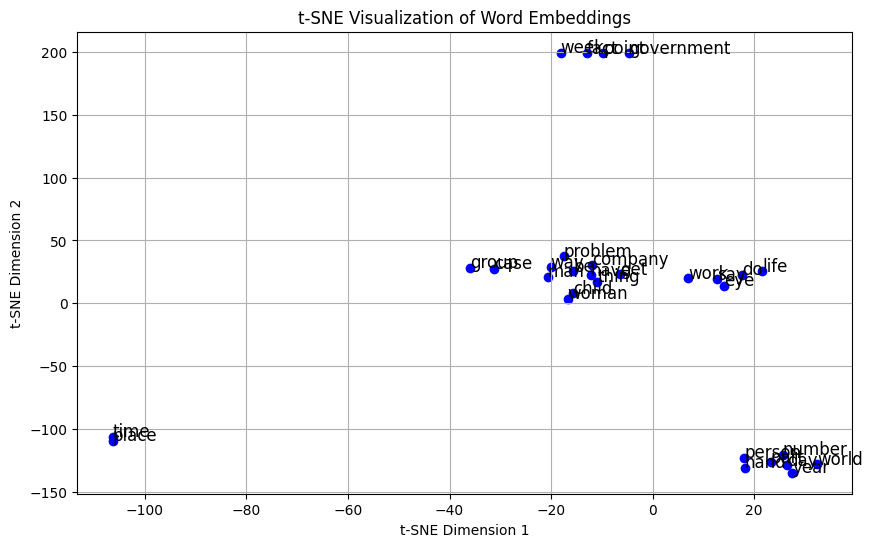

In [121]:
# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color='blue')

# Annotate each point with the corresponding word
for i, word in enumerate(words):
    plt.annotate(word, (X_embedded[i, 0], X_embedded[i, 1]), fontsize=12)

# Set plot title and labels
plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 150 (\x96) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


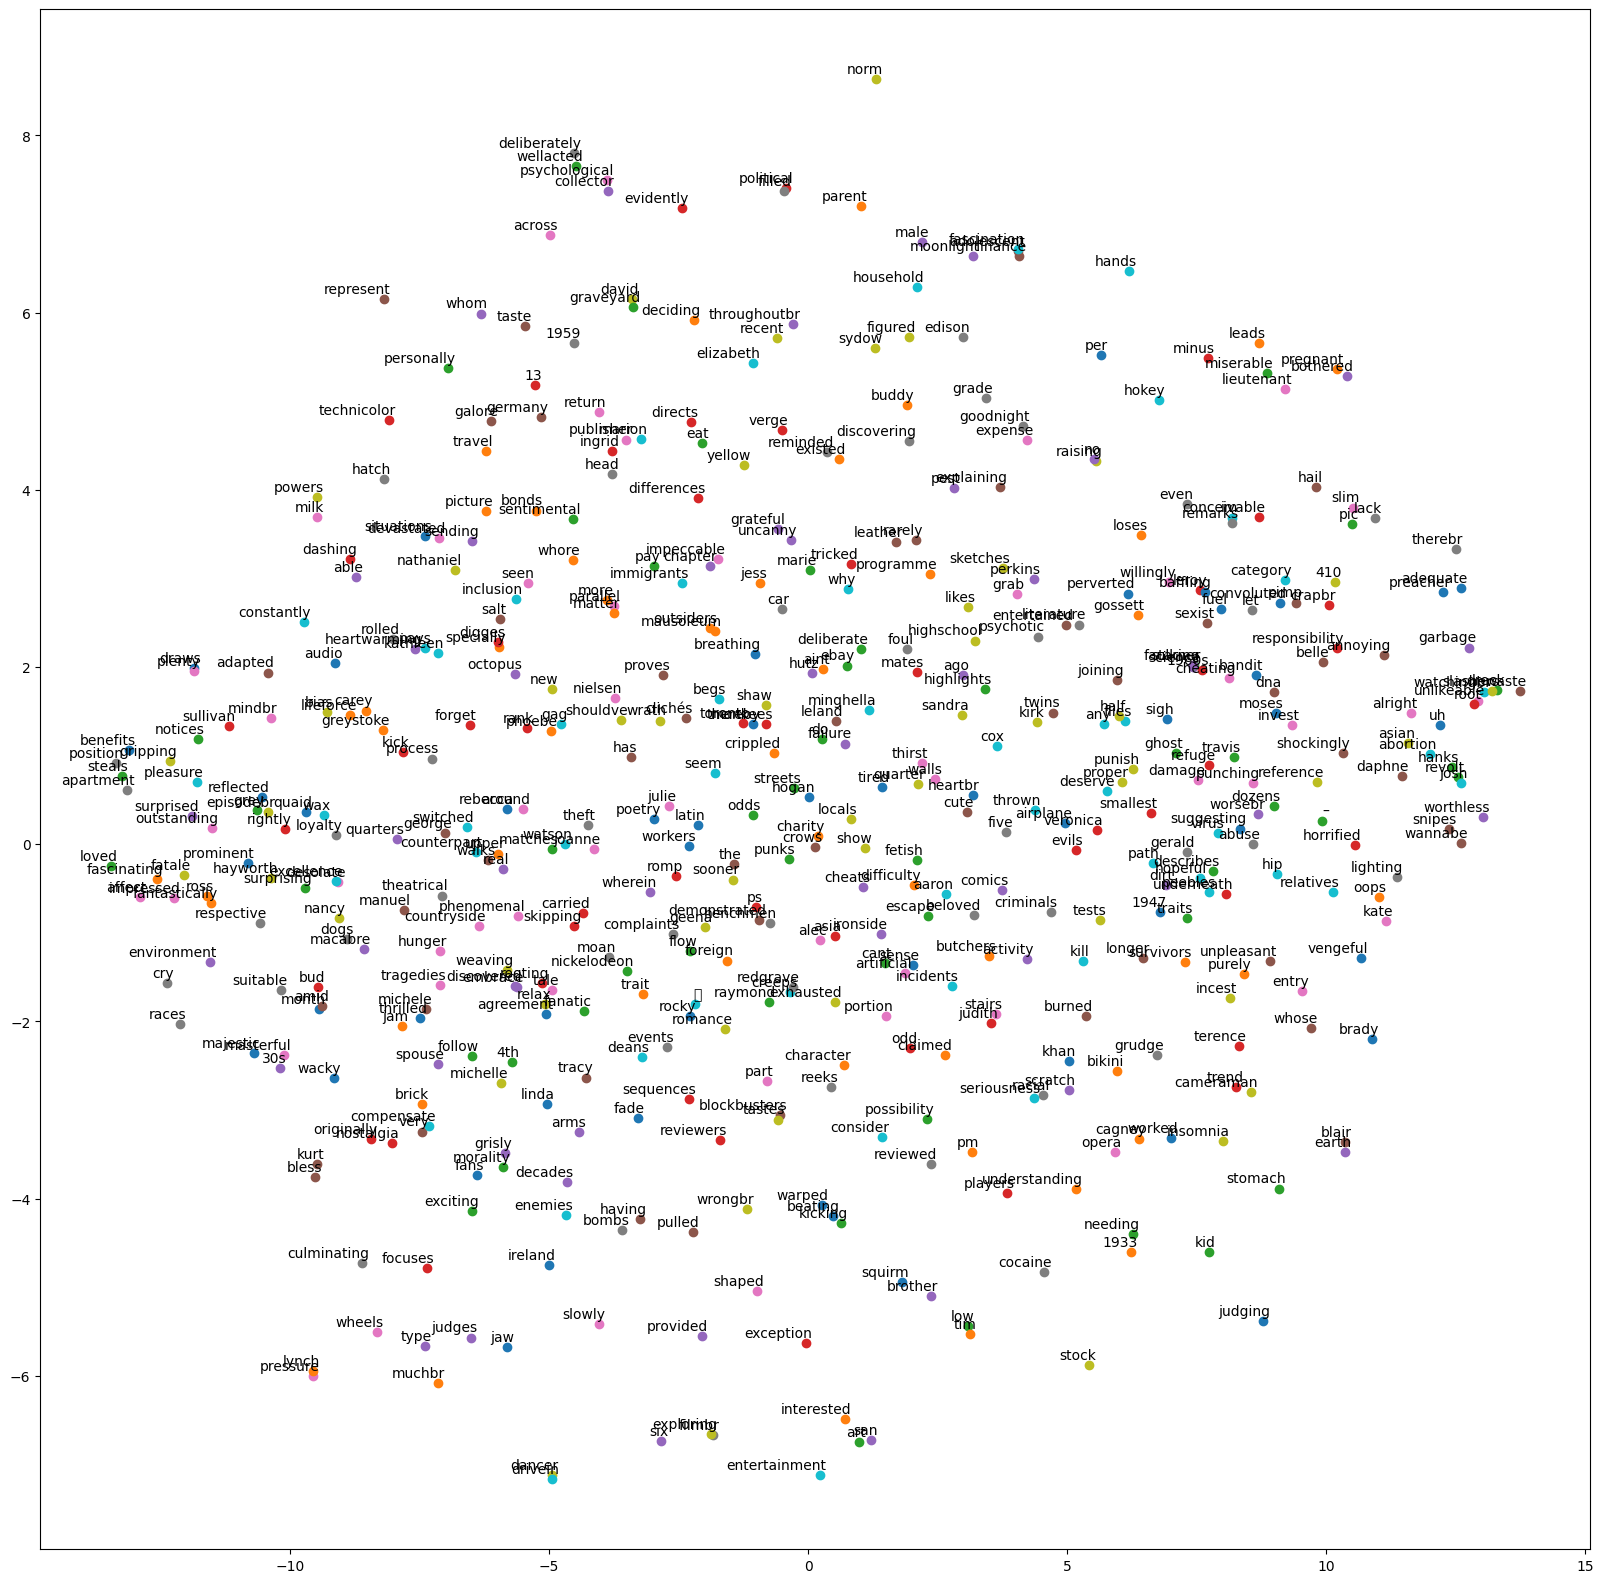

In [122]:
import random
from sklearn.manifold import TSNE

def get_embeddings(words, vocabulary):
    embeddings_table = model.layers[1].get_weights()[0]
    embeddings = []
    for word in words:
        index = vocabulary.index(word)
        embedding = embeddings_table[index]
        embeddings += [embedding]
    embeddings = np.array(embeddings)
    return embeddings

def render_embeddings(words=None):

    encoder = model.layers[0]
    vocabulary = encoder.get_vocabulary()

    if words is None:
        words = random.sample(vocabulary, 500)
    else:
        words = [word for word in words if word in vocabulary]

    embeddings = get_embeddings(words, vocabulary)

    tsne = TSNE(perplexity=40, n_components=2, init="pca", n_iter=2500, random_state=23)
    vectors = tsne.fit_transform(embeddings)

    x = [value[0] for value in vectors]
    y = [value[1] for value in vectors]

    plt.figure(figsize=(20, 20))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(
            words[i],
            xy=(x[i], y[i]),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom'
        )
    plt.show()
    plt.close()

render_embeddings()